In [2]:
from gwdetectors import *
from postprocessing import * 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import glob
from decimal import Decimal

In [72]:
filepath = '/fs/lustre/cita/jewelcao/results/hp_true/hl/Perth_Ulaanbaatar' 

files = glob.glob(f'{filepath}/results*.pickle')
print(len(files))

dicts = []
for i in range(len(files)): 
    with open(f"{filepath}/results_{i}.pickle", "rb") as f:
        result = pickle.load(f)
        dicts.append(result)

merged_results = merge_dicts(dicts)

44


In [73]:
newpath = '/fs/lustre/cita/jewelcao/plots/hp_true/hl/Perth_Ulaanbaatar'

In [74]:
if os.path.exists(newpath):
    response = input(f"File '{filename}' already exists. Overwrite? (y/N): ")
    if response.lower() not in ['y', 'yes']:
        print("Operation cancelled.")
        pass
    else:
        os.mkdir(newpath)
else: 
    os.mkdir(newpath)

In [75]:
merged_results.keys()

dict_keys(['true pole', 'true azim', 'true psi', 'match', 'filters', 'snrs', 'sky_coords', 'vars'])

In [76]:
with open(f"{filepath}/info.pickle", "rb") as f: 
    info = pickle.load(f)
    print(info)

{'true_mode': ['hp'], 'strain_mode': ['hl'], 'a': 3747.405725013321, 'A': 1e-23, 'c': 0.001, 'dt': 0, 'phi': 0, 'geocent': 0, 'coord': 'geographic', 'network': Network(
  TwoArmDetector( H_aligo-design, location = (-7.209704e-03, -1.279117e-02, 1.534512e-02) sec, arms = ( (-2.987302e-06, 1.067179e-05, 7.430539e-06) sec, (-1.219481e-05, 3.481614e-07, -5.402717e-06) sec, ) psd = OneSidedPowerSpectralDensity(aligo-design, freq within [5.000000e+00 5.000000e+03])), long-wavelength approximation = False, ),
  TwoArmDetector( L_aligo-design, location = (-2.477582e-04, -1.833363e-02, 1.075496e-02) sec, arms = ( (-1.273647e-05, -1.889051e-06, -3.498275e-06) sec, (3.972636e-06, -6.509975e-06, -1.094817e-05) sec, ) psd = OneSidedPowerSpectralDensity(aligo-design, freq within [5.000000e+00 5.000000e+03])), long-wavelength approximation = False, ),
  TwoArmDetector( V_advirgo-design, location = (1.516507e-02, 2.811911e-03, 1.460536e-02) sec, arms = ( (-7.009431e-06, 2.086338e-06, 6.830342e-06) sec

In [77]:
CE_filters = np.array([np.sum(merged_results['filters'][i][4:])**2 
                       for i in range(len(merged_results['filters']))])**0.5
CE_snrs = np.array([np.sum(merged_results['snrs'][i][4:])**2 
                    for i in range(len(merged_results['snrs']))])**0.5
others_filters = np.array([np.sum(np.array(merged_results['filters'][i][:4])**2) 
                           for i in range(len(merged_results['filters']))])**0.5
others_snrs = np.array([np.sum(np.array(merged_results['snrs'][i][:4])**2) 
                        for i in range(len(merged_results['snrs']))])**0.5

In [78]:
CE_match = np.abs(CE_filters/CE_snrs)
others_match = np.abs(others_filters / others_snrs)

In [79]:
summary_statistics = {}
CE_stats = {'average CE match': np.mean(CE_match), 'median CE match':np.median(CE_match)} 
excluding_CE_stats = {'average match excluding CE': np.mean(others_match), 
                      'median match excluding CE':np.median(others_match)}

In [80]:
others_thresholds = {}
CE_thresholds={}
for B in [2, 10, 50, 100]:
    others_threshold = approx_threshold(np.full(np.shape(others_match), B), others_match)
    CE_threshold = approx_threshold(np.full(np.shape(CE_match), B), CE_match)
    minimum_threshold = np.min(others_threshold)
    average_threshold = np.mean(others_threshold)
    median_threshold = np.median(others_threshold)
    average_CE_threshold = np.mean(CE_threshold)
    median_CE_threshold = np.median(CE_threshold)
    minimum_CE_threshold = np.min(CE_threshold)
    others_thresholds[f'{B}'] =  {'average threshold':average_threshold, 
                                  'median threshold':median_threshold,
                                 'minimum threshold':minimum_threshold}
    CE_thresholds[f'{B}'] =  {'average threshold':average_CE_threshold, 
                              'median threshold':median_CE_threshold,
                             'minimum threshold':minimum_threshold}
standard_threshold = np.sqrt(1 / np.abs(others_match**2 - 1))
others_thresholds['standard'] = {'average threshold':np.mean(standard_threshold),
                                'median threshold':np.median(standard_threshold),
                                'minimum threshold':np.min(standard_threshold)}
standard_CE_threshold = np.sqrt(1 / np.abs(CE_match**2 - 1))
CE_thresholds['standard'] = {'average threshold':np.mean(standard_CE_threshold),
                                'median threshold':np.median(standard_CE_threshold),
                                'minimum threshold':np.min(standard_CE_threshold)}
excluding_CE_stats['thresholds'] = others_thresholds
CE_stats['thresholds'] = CE_thresholds

In [81]:
summary_statistics['CE'] = CE_stats
summary_statistics['excluding CE'] = excluding_CE_stats

In [82]:
summary_statistics

{'CE': {'average CE match': 0.7617124391493824,
  'median CE match': 0.9857050035439758,
  'thresholds': {'2': {'average threshold': 8.72667704774529,
    'median threshold': 6.9884203570097805,
    'minimum threshold': 1.177410022537449},
   '10': {'average threshold': 15.905378847422107,
    'median threshold': 12.737204862187044,
    'minimum threshold': 2.1459660263293983},
   '50': {'average threshold': 20.73179346473432,
    'median threshold': 16.602251543582085,
    'minimum threshold': 2.7971496225887416},
   '100': {'average threshold': 22.493602480706485,
    'median threshold': 18.013127862829446,
    'minimum threshold': 3.0348542588269334},
   'standard': {'average threshold': 7.411757060723165,
    'median threshold': 5.935417758784988,
    'minimum threshold': 1.0000000643036664}}},
 'excluding CE': {'average match excluding CE': 0.463626947300157,
  'median match excluding CE': 0.41824265597977395,
  'thresholds': {'2': {'average threshold': 2.798971643352622,
    'med

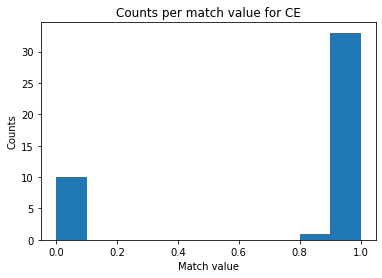

In [83]:
plt.title('Counts per match value for CE')
plt.xlabel('Match value')
plt.ylabel('Counts')
plt.hist(CE_match, bins=10)
plt.savefig(f'{newpath}/hist_CE')
plt.show()

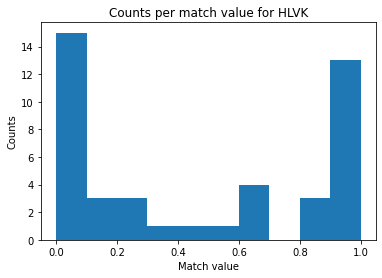

In [84]:
plt.title('Counts per match value for HLVK')
plt.xlabel('Match value')
plt.ylabel('Counts')
plt.hist(others_match, bins=10)
plt.savefig(f'{newpath}/hist_HLVK')
plt.show()

In [85]:
with open(f'{newpath}/summary_stats.pickle', 'wb') as fp:
    pickle.dump(summary_statistics, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [86]:
vars_= [item[0] for item in merged_results['vars']]
psis, t0s, phis = zip(*vars_)

In [87]:
sky_coords_ = [item[0] for item in merged_results['sky_coords']]
azims = merged_results['true azim']
poles = merged_results['true pole']
strain_azims, strain_poles = zip(*sky_coords_)

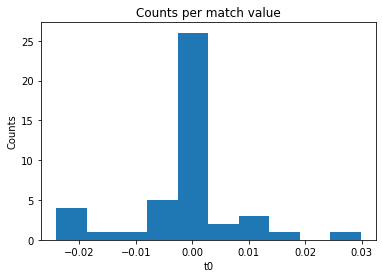

In [88]:
plt.title('Counts per match value')
plt.xlabel('t0')
plt.ylabel('Counts')
plt.hist(t0s, bins=10)
plt.savefig(f'{newpath}/t0_hist')
plt.show()

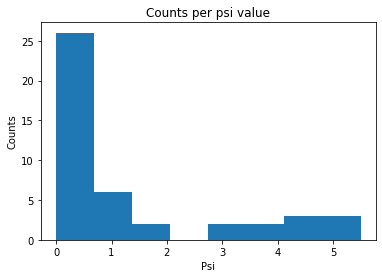

In [89]:
plt.title('Counts per psi value')
plt.xlabel('Psi')
plt.ylabel('Counts')
plt.hist(psis, bins=8)
plt.plot()
plt.savefig(f'{newpath}/psi_hist')
plt.show()

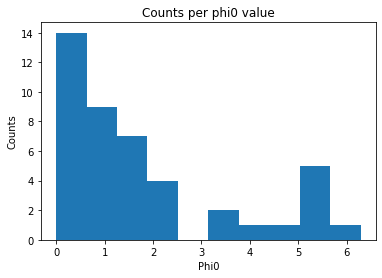

In [90]:
plt.title('Counts per phi0 value')
plt.xlabel('Phi0')
plt.ylabel('Counts')
plt.hist(phis, bins=10)
plt.savefig(f'{newpath}/phi0_hist')
plt.show()

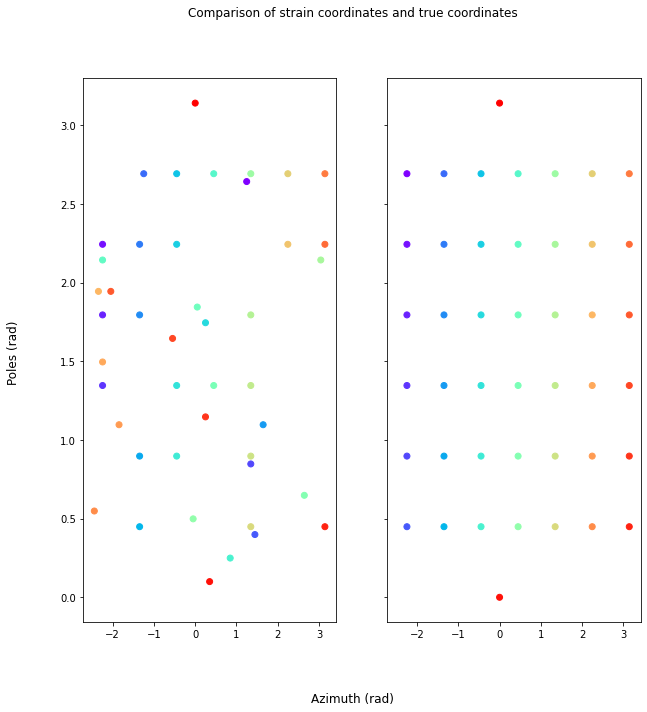

In [91]:
## NOTE: since I only got the first value in max_sky_coords, it sort of makes sense that everything is at 
# azim = -pi, since that's where the array starts
# Part of it might also be that the difference is so small np.where doesn't register it

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0,1,len(azims)))
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle('Comparison of strain coordinates and true coordinates')
fig.supxlabel('Azimuth (rad)')
fig.supylabel('Poles (rad)')
ax1.scatter(strain_azims, strain_poles, c=colors)
ax2.scatter(azims, poles, c=colors)
plt.savefig(f'{newpath}/coordinate_comparison')
plt.show()

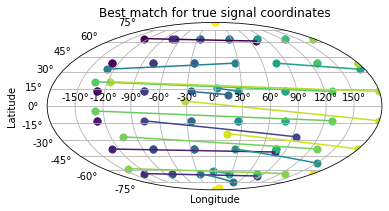

In [92]:
color_map = plt.cm.viridis(np.linspace(0, 1, len(azims)))

fig = plt.figure()
ax = fig.add_subplot(111, projection="mollweide")
for i in range(len(azims)):
    ax.scatter(strain_azims[i], np.array(strain_poles[i]) - np.pi/2, c=[color_map[i]], s=50, 
               vmin=0.8, vmax=1.0)
    ax.scatter(azims[i], np.array(poles[i]) - np.pi/2, c=[color_map[i]], s=50, 
               vmin=0.8, vmax=1.0)
    ax.plot([strain_azims[i], azims[i]], [np.array(strain_poles[i]) - np.pi/2, np.array(poles[i]) - np.pi/2],
            c=color_map[i])
ax.grid(True)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Best match for true signal coordinates")
plt.savefig(f'{newpath}/coordinate_comparison_skymap')
plt.show()

# Checking psi value for x, + test

In [27]:
ind=np.where(np.array(psis) != np.pi/4)[0]

azim_ind = [azims[i] for i in ind]
pole_ind = [poles[i] for i in ind]
strain_azims_ind=[strain_azims[i] for i in ind]
strain_poles_ind=[strain_poles[i] for i in ind]

coords_ind = list(zip(azim_ind, pole_ind))
strain_coords_ind = list(zip(strain_azims_ind, strain_poles_ind))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [30]:
ind=np.where(np.array(psis) == np.pi/4)[0]

azim_ind = [azims[i] for i in ind]
pole_ind = [poles[i] for i in ind]
strain_azims_ind=[strain_azims[i] for i in ind]
strain_poles_ind=[strain_poles[i] for i in ind]

print(azim_ind, strain_azims_ind)

[-2.356194490192345, -2.356194490192345, -1.5707963267948966, -1.5707963267948966, -0.7853981633974483, -0.7853981633974483, 0.0, 0.0, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 1.5707963267948966, 2.356194490192345, 2.356194490192345] [-2.356194490192345, -2.5034566458293663, -3.0925052683774528, -3.0925052683774528, -0.7853981633974483, -2.0125827937059615, -3.0925052683774528, -3.141592653589793, -2.3071071049800045, 0.6381360077604268, 0.7853981633974483, -0.3436116964863838, -3.141592653589793, 1.1290098598838316, 2.356194490192345]


# Server resolution

In [13]:
names_range = [2, 8, 16, '-f', 45, 64]

matches_range = {}
azim_pole = []
for i in range(2):
    matches = []
    for name in names_range: 
        with open(f"../results/server_resolution/results_{i}_{name}.pickle",'rb') as file: 
            result = pickle.load(file)
            matches.append(result['match'])
    matches_range[f'{i}'] = matches

In [14]:
names_num = [8, 16, 32, 45, 64, 72, 90, 128, 180]

matches_num = {}
for i in range(2):
    matches = []
    for name in names_num: 
        with open(f"../results/server_resolution/results_{i}_num{name}.pickle",'rb') as file: 
            result = pickle.load(file)
            matches.append(result['match'])
    matches_num[f'{i}'] = matches

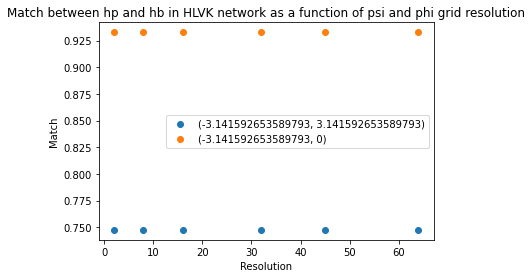

In [20]:
names_range = [2, 8, 16, 32, 45, 64]
true_coords = [(-np.pi, np.pi), (-np.pi, 0), (np.pi, np.pi), (np.pi, 0)]

plt.title('Match between hp and hb in HLVK network as a function of psi and phi grid resolution')
plt.xlabel('Resolution')
plt.ylabel('Match')
plt.scatter(names_range, matches_range[f'{0}'], label=f'{true_coords[0]}')
plt.scatter(names_range, matches_range[f'{1}'], label=f'{true_coords[1]}')
plt.legend()
plt.savefig('/fs/lustre/cita/jewelcao/plots/psi_phi_resolution')
plt.show()

info_range = {'a':'CE_fsr', 'c':1e-4, 'freq_res':120, 'strain_res':45, 
        'true_mode': 'hp', 'strain_mode':'hb', 'network':'HLVK'}

with open('/fs/lustre/cita/jewelcao/plots/psi_phi_resolution_meta.pickle', 'wb') as fp:
    pickle.dump(info_range, fp, protocol=pickle.HIGHEST_PROTOCOL)

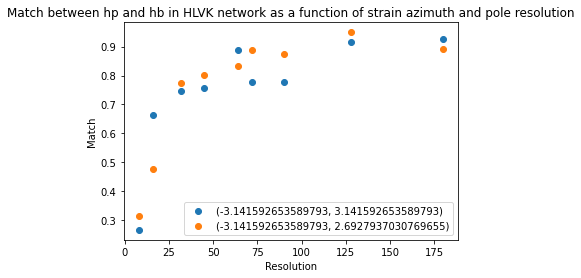

In [21]:
names_range = [8, 16, 32, 45, 64, 72, 90, 128, 180]
true_coords = [(-np.pi, np.pi), (-3.141592653589793, 2.6927937030769655), (np.pi, np.pi), (np.pi, 0)]

plt.title('Match between hp and hb in HLVK network as a function of strain azimuth and pole resolution')
plt.xlabel('Resolution')
plt.ylabel('Match')
plt.scatter(names_num, matches_num[f'{0}'], label=f'{true_coords[0]}')
plt.scatter(names_num, matches_num[f'{1}'], label=f'{true_coords[1]}')
plt.legend()
plt.savefig('/fs/lustre/cita/jewelcao/plots/strain_resolution')
plt.show()

info_num = {'a':'CE_fsr', 'c':1e-4, 'freq_res':120, 'psi_phi_res':16, 
        'true_mode': 'hp', 'strain_mode':'hb', 'network':'HLVK'}

with open('/fs/lustre/cita/jewelcao/plots/strain_resolution_meta.pickle', 'wb') as fp:
    pickle.dump(info_num, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
names_numpts = [80, 120, 160, 200, 240]

matches_numpts = {}
for i in range(2):
    matches = []
    for name in names_numpts: 
        with open(f"../results/server_resolution/results_{i}_numpts{name}.pickle",'rb') as file: 
            result = pickle.load(file)
            matches.append(result['match'])
    matches_numpts[f'{i}'] = matches

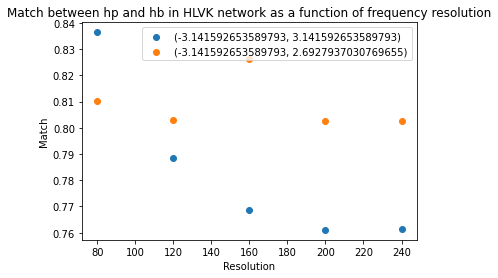

In [23]:
true_coords = [(-np.pi, np.pi), (-3.141592653589793, 2.6927937030769655), (np.pi, np.pi), (np.pi, 0)]

plt.title('Match between hp and hb in HLVK network as a function of frequency resolution')
plt.xlabel('Resolution')
plt.ylabel('Match')
plt.scatter(names_numpts, matches_numpts['0'], label=f'{true_coords[0]}')
plt.scatter(names_numpts, matches_numpts['1'], label=f'{true_coords[1]}')
plt.legend()
plt.savefig('/fs/lustre/cita/jewelcao/plots/freq_resolution')
plt.show()

info_numpts = {'a':'CE_fsr', 'c':1e-4, 'strain_res':45, 'psi_phi_res':16, 
        'true_mode': 'hp', 'strain_mode':'hb', 'network':'HLVK'}

with open('/fs/lustre/cita/jewelcao/plots/freq_resolution_meta.pickle', 'wb') as fp:
    pickle.dump(info_numpts, fp, protocol=pickle.HIGHEST_PROTOCOL)

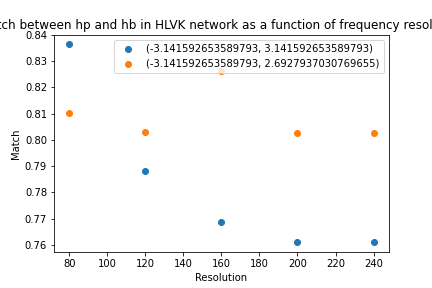

In [24]:
# save and store figures

from IPython.display import Image
Image(filename='/fs/lustre/cita/jewelcao/plots/freq_resolution.png') 

In [25]:
with open("/fs/lustre/cita/jewelcao/plots/freq_resolution_meta.pickle",'rb') as file: 
    result = pickle.load(file)
    print(result)

{'a': 'CE_fsr', 'c': 0.0001, 'strain_res': 45, 'psi_phi_res': 16, 'true_mode': 'hp', 'strain_mode': 'hb', 'network': 'HLVK'}


In [26]:
names_numpts = [80, 120, 160, 200, 240]

matches_numpts = {}
for i in range(2):
    matches = []
    for name in names_numpts: 
        with open(f"../results/frequency_resolution/results_{i}_numpts{name}.pickle",'rb') as file: 
            result = pickle.load(file)
            matches.append(result['match'])
    matches_numpts[f'{i}'] = matches

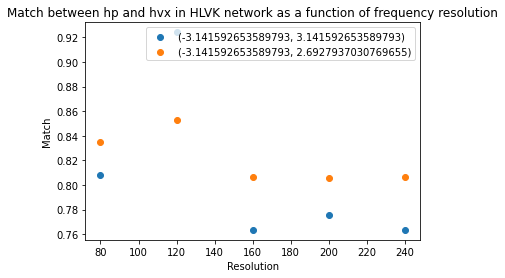

In [28]:
true_coords = [(-np.pi, np.pi), (-3.141592653589793, 2.6927937030769655), (np.pi, np.pi), (np.pi, 0)]

plt.title('Match between hp and hvx in HLVK network as a function of frequency resolution')
plt.xlabel('Resolution')
plt.ylabel('Match')
plt.scatter(names_numpts, matches_numpts['0'], label=f'{true_coords[0]}')
plt.scatter(names_numpts, matches_numpts['1'], label=f'{true_coords[1]}')
plt.legend()
plt.savefig('/fs/lustre/cita/jewelcao/plots/freq_resolution_hvx')
plt.show()

info_numpts = {'a':'CE_fsr', 'c':1e-4, 'strain_res':45, 'psi_phi_res':16, 
        'true_mode': 'hp', 'strain_mode':'hvx', 'network':'HLVK'}

with open('/fs/lustre/cita/jewelcao/plots/freq_resolution_hvx_meta.pickle', 'wb') as fp:
    pickle.dump(info_numpts, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Current run

In [23]:
true_poles = []
true_azims = []
matches = []

for i in range(8): 
    with open(f"results/current_run/results_{i}.pickle",'rb') as file: 
        result = pickle.load(file)
        true_poles.append(result['true pole'])
        true_azims.append(result['true azim'])
        matches.append(result['match'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


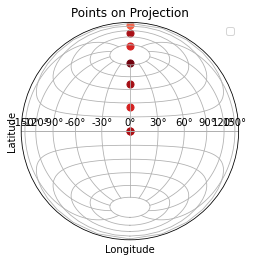

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="lambert")
for i in range(8):
    ax.scatter(true_azims[i], true_poles[i], c=matches[i], s=50, vmin=0.8, vmax=1.0, cmap='Reds')
ax.grid(True)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Points on Projection")
ax.legend()
plt.show()

## Plots

In [3]:
hp_hp = np.loadtxt('results/phi_optimization/hp_hp.txt')
hp_hvx = np.loadtxt('results/phi_optimization/hp_hvx.txt')
hp_hb = np.loadtxt('results/phi_optimization/hp_hb.txt')

In [4]:
num=45

phi_plt = np.linspace(-np.pi, np.pi, num-1)
theta_plt = np.linspace(-np.pi/2., np.pi/2.,num-1)
Phi, Theta = np.meshgrid(phi_plt, theta_plt, indexing='ij')

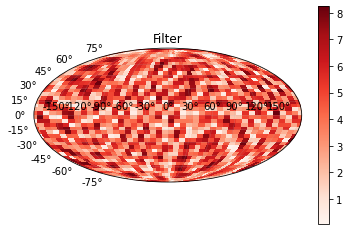

In [5]:
# Plot filter over sky locations

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
im = ax.pcolormesh(Phi,Theta, hp_hp, cmap=plt.cm.Reds) 
plt.colorbar(im)
plt.title('Filter')
ax.grid(alpha=0.3, linewidth=0.5)
plt.show()

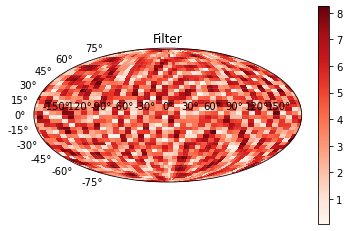

In [6]:
# Plot filter over sky locations

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
im = ax.pcolormesh(Phi,Theta, hp_hvx, cmap=plt.cm.Reds) 
plt.colorbar(im)
plt.title('Filter')
ax.grid(alpha=0.3, linewidth=0.5)
plt.show()

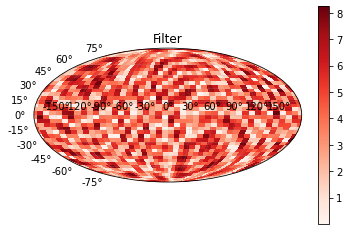

In [8]:
# Plot filter over sky locations

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
im = ax.pcolormesh(Phi,Theta, hp_hb, cmap=plt.cm.Reds) 
plt.colorbar(im)
plt.title('Filter')
ax.grid(alpha=0.3, linewidth=0.5)
plt.show()

### Summarized results

In [4]:
rows = ['pole', 'azim', 'psi', 't0', 'geocent', 'modes', 'match']

df_read = pd.read_csv(f'results/increased_frequency/hp_true.csv', header=None)
df_read

,0,1,2,3,4
0,info,true_params,hp,hvx,hb
1,29979.24580000003,NaN,NaN,NaN,NaN
2,1e-23,NaN,NaN,NaN,NaN
3,1,NaN,NaN,NaN,NaN
4,0,NaN,NaN,NaN,NaN
5,"Network(\n TwoArmDetector( H_aligo-design, lo...",NaN,NaN,NaN,NaN
6,NaN,0,0.0,0.0,0.0
7,NaN,0,-1.5707963267948966,2.2847946571562137,-2.99879298751753
8,NaN,0,1.5707963267948966,1.0122909661567112,0.0
9,NaN,0,0.0,0.0,0.0


In [11]:
df_read = pd.read_csv(f'results/standard/hp_true.csv', header=None)
df_read

,0,1,2,3,4
0,info,true_params,hp,hvx,hb
1,100,NaN,NaN,NaN,NaN
2,1e-23,NaN,NaN,NaN,NaN
3,1,NaN,NaN,NaN,NaN
4,0,NaN,NaN,NaN,NaN
5,"Network(\n TwoArmDetector( H_aligo-design, lo...",NaN,NaN,NaN,NaN
6,NaN,0,0.0,0.0,0.0
7,NaN,0,-2.8559933214452666,-2.5703939893007397,-2.99879298751753
8,NaN,0,1.8500490071139892,2.4085543677521746,1.6057029118347832
9,NaN,0,0.0,0.0,0.0


In [12]:
df_read = pd.read_csv(f'results/shortened_timespan/hp_true.csv', header=None)
df_read

,0,1,2,3,4
0,info,true_params,hp,hvx,hb
1,100,NaN,NaN,NaN,NaN
2,1e-23,NaN,NaN,NaN,NaN
3,0.01,NaN,NaN,NaN,NaN
4,0,NaN,NaN,NaN,NaN
5,"Network(\n TwoArmDetector( H_aligo-design, lo...",NaN,NaN,NaN,NaN
6,NaN,0,0.0,0.0,0.0
7,NaN,0,3.141592653589793,2.427594323228477,-2.99879298751753
8,NaN,0,0.0,1.117010721276371,0.0
9,NaN,0,0.0,0.0,0.0


In [4]:
df_read = pd.read_csv(f'results/phi_optimization/hp_true.csv', header=None)
df_read

,0,1,2,3,4
0,info,true_params,hp,hvx,hb
1,100,NaN,NaN,NaN,NaN
2,1e-23,NaN,NaN,NaN,NaN
3,1,NaN,NaN,NaN,NaN
4,0,NaN,NaN,NaN,NaN
5,"Network(\n TwoArmDetector( H_aligo-design, lo...",NaN,NaN,NaN,NaN
6,NaN,0,0.0,0.0,0.0
7,NaN,0,-1.5707963267948966,-0.42839899821678973,-2.99879298751753
8,NaN,0,0.0,1.3962634015954636,0.0
9,NaN,0,0.0,0.0,0.0


In [3]:
df_read = pd.read_csv(f'results/more_detectors/hp_true.csv', header=None)
df_read

,0,1,2,3
0,info,true_params,hvx,hb
1,100,NaN,NaN,NaN
2,1e-23,NaN,NaN,NaN
3,1,NaN,NaN,NaN
4,0,NaN,NaN,NaN
5,"Network(\n TwoArmDetector( H_aligo-design, lo...",NaN,NaN,NaN
6,NaN,0,0.0,0.0
7,NaN,0,-2.8559933214452666,-2.99879298751753
8,NaN,0,1.3962634015954636,0.0
9,NaN,0,NaN,NaN
